# Experiment  1 How well can cognitive scores predict diagnosis
In this experiment we use logistic regression to predict the outcome variable (the diagnosis of a sample) 

Eight domain scores were used as inputs for the classifier. These domain scores correspond to a combination of a number of different assessments which putatively measure some aspect of cognition within that domain. The domain scores are Speed of Processing(SOP), ATVI(not sure what this is), NVLM, NVWM, Reasoning and Proccessing Speed(RPS), Visual Spatial Ability (VISPA), Verbal Working Memory(VWM), VLM. We used the covariate features of Sex, and Age to create a projection matrix as described in the previous section were we predict diagnosis using the structural MRI features, and then remove the effects of covariates using the same projection matrix approach.

In [11]:
import os
import utils
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

In [2]:
cog_base = '/storage/gablab001/data/genus/current/structured/cognitive'
cog_file = 'GENUS_neuropsych_data_Domain_Scores.csv'

In [3]:
cog = pd.read_csv(os.path.join(cog_base, cog_file))

In [4]:
cog.head()

,FID,IID,SOPdomainAvgZ,ATVIdomainAvgZ,VWMdomainAvgZ,NVWMdomainAvgZ,VLMdomainAvgZ,NVLMdomainAvgZ,RPSdomainAvgZ,VISPAdomainAvgZ
0,H001,06H001,-0.994502,NaN,-0.058660,NaN,0.254863,0.733938,0.495773,NaN
1,H002,06H002,-0.647871,NaN,NaN,NaN,NaN,NaN,1.258445,NaN
2,H003,06H003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H004,06H004,-0.565002,NaN,0.515166,NaN,0.142402,1.153805,0.109642,NaN
4,H005,06H005,-0.564811,NaN,-1.029433,NaN,-1.241900,-1.582192,0.826519,NaN


In [10]:
cog.apply(pd.isnull).sum()

FID                   0
IID                   0
SOPdomainAvgZ       878
ATVIdomainAvgZ     3512
VWMdomainAvgZ      1390
NVWMdomainAvgZ     4844
VLMdomainAvgZ      2159
NVLMdomainAvgZ     5032
RPSdomainAvgZ      2398
VISPAdomainAvgZ    2402
dtype: int64

In [11]:
cog.dropna().shape

(547, 10)

In [5]:
fam_file = '/storage/gablab001/data/genus/current/structured/fam/FAM_N5338_EUR.csv'
fam = pd.read_csv(fam_file)

In [17]:
fam.head()

,IID,FID,pid,mid,sex,affected
0,1106.04,1106,0,0,1,1
1,11260-1,11260,0,0,2,2
2,G_93180,GEN_03_1151,0,0,1,1
3,RPG6034,RPG6034,0,0,1,2
4,32-1-2-00-009,CIDAR_02_2009-2009,0,0,1,2


In [6]:
ids = np.intersect1d(cog.IID.values, fam.IID.values)

In [19]:
ids

array(['00225_A', '00226_B', '00228_B', ..., 'U042411', 'U042561',
       'U042562'], dtype=object)

In [7]:
fam_reduced = fam.set_index('IID').loc[ids].reset_index().drop_duplicates('IID')
cog_reduced = cog.set_index('IID').loc[ids].reset_index().drop_duplicates('IID')
print(fam_reduced.shape, cog_reduced.shape)

((4926, 6), (4926, 10))


In [30]:
fam_reduced.head()

,IID,FID,pid,mid,sex,affected
0,00225_A,DEC_JWS_00225,0,0,2,2
1,00226_B,DEC_JWS_00226,0,0,1,2
2,00228_B,DEC_JWS_00228,0,0,1,2
3,00233_B,DEC_JWS_00233,0,0,1,2
4,06H001,H001,0,0,2,1


In [31]:
cog_reduced.head()

,IID,FID,SOPdomainAvgZ,ATVIdomainAvgZ,VWMdomainAvgZ,NVWMdomainAvgZ,VLMdomainAvgZ,NVLMdomainAvgZ,RPSdomainAvgZ,VISPAdomainAvgZ
0,00225_A,DEC_JWS_00225,-2.397181,NaN,-1.539926,NaN,-3.778566,NaN,0.981764,-0.807805
1,00226_B,DEC_JWS_00226,-1.113352,NaN,-1.579818,NaN,-1.492848,NaN,3.559235,-1.213359
2,00228_B,DEC_JWS_00228,-0.465473,NaN,-0.469545,NaN,-0.126744,NaN,1.579159,1.236407
3,00233_B,DEC_JWS_00233,-1.682203,NaN,-1.914997,NaN,-2.865740,NaN,4.003487,-1.697674
4,06H001,H001,-0.994502,NaN,-0.058660,NaN,0.254863,0.733938,0.495773,NaN


In [33]:
(fam_reduced.IID.values == cog_reduced.IID.values).mean()

1.0

In [8]:
# 1 = patient, 0 = HC
cog_reduced['GROUP'] = fam_reduced.affected.values - 1
cog_reduced['SEX'] = fam_reduced.sex.values

In [43]:
cog_reduced.head()

,IID,FID,SOPdomainAvgZ,ATVIdomainAvgZ,VWMdomainAvgZ,NVWMdomainAvgZ,VLMdomainAvgZ,NVLMdomainAvgZ,RPSdomainAvgZ,VISPAdomainAvgZ,GROUP,SEX
0,00225_A,DEC_JWS_00225,-2.397181,NaN,-1.539926,NaN,-3.778566,NaN,0.981764,-0.807805,1,2
1,00226_B,DEC_JWS_00226,-1.113352,NaN,-1.579818,NaN,-1.492848,NaN,3.559235,-1.213359,1,1
2,00228_B,DEC_JWS_00228,-0.465473,NaN,-0.469545,NaN,-0.126744,NaN,1.579159,1.236407,1,1
3,00233_B,DEC_JWS_00233,-1.682203,NaN,-1.914997,NaN,-2.865740,NaN,4.003487,-1.697674,1,1
4,06H001,H001,-0.994502,NaN,-0.058660,NaN,0.254863,0.733938,0.495773,NaN,0,2


In [44]:
cog_reduced.apply(pd.isnull).mean() # to get percentages

IID                0.000000
FID                0.000000
SOPdomainAvgZ      0.131547
ATVIdomainAvgZ     0.485384
VWMdomainAvgZ      0.080187
NVWMdomainAvgZ     0.585668
VLMdomainAvgZ      0.270402
NVLMdomainAvgZ     0.646366
RPSdomainAvgZ      0.359927
VISPAdomainAvgZ    0.276289
GROUP              0.000000
SEX                0.000000
dtype: float64

In [9]:
# use everything while dropping missing values
cog_allscores_reduced = cog_reduced.dropna()
print(cog_allscores_reduced.shape)

(448, 12)


To test how well the cognitive domain scores features predict the diagnosis we employ a nested cross validation scheme. The model of choice is Logistic Regression with and L1 penalty to impose sparcity on the feature space. We picked an L1 penalty because we want to find a subset of the feature space that best predicts the outcome. The best regularization parameter was chosen in the inner loop of the nested cross validation scheme and then it was applied to the other loop. This paramter would determind the features which would be considered in the model at the time of classification. Two cross validators(CV) were chosen, for the outer loop a stratisfied shuffle split was selection, this CV was run over 400 iterations. It randomly sampled from the data in a stratifed manner which preserves the relative perctanges of patients and controls in the entire sample. The inner CV was stratified k-fold, where k = 5. 

The preprocessing steps before the logistic regression model was applied to the data were demeaning by subtracting the feature mean from each observation in that feature, and scaling by dividing each observation within the feature by the feature standard deviation (after demeaning). The accuracy measured we used was Receiver Operating Characteristic Area Under the Curve. 

In [42]:
clf = Pipeline([
    ('scale', StandardScaler()),
    ('lg', linear_model.LogisticRegressionCV(
        penalty='l1',
        solver='liblinear',
        cv = StratifiedKFold(n_splits=5, shuffle=True)
        ))
    ])

In [43]:
scores = cross_val_score(clf, 
                         X=cog_allscores_reduced[[i for i in utils.domain_scores]].values, 
                         y=cog_allscores_reduced['GROUP'].values,
                         cv=StratifiedShuffleSplit(n_splits=400),
                         scoring=make_scorer(roc_auc_score))

In [44]:
# n_subjects here is 448
scores, np.mean(scores)

(array([ 0.80481283,  0.71256684,  0.78877005,  0.78877005,  0.8342246 ,
         0.71256684,  0.76069519,  0.75802139,  0.78877005,  0.80481283,
         0.75935829,  0.77406417,  0.65374332,  0.84893048,  0.86497326,
         0.87967914,  0.74465241,  0.89438503,  0.77406417,  0.81951872,
         0.77406417,  0.81818182,  0.80347594,  0.70053476,  0.80481283,
         0.74331551,  0.74331551,  0.77406417,  0.98529412,  0.80481283,
         0.81818182,  0.57754011,  0.71256684,  0.86363636,  0.77406417,
         0.8342246 ,  0.68181818,  0.97058824,  0.78877005,  0.89438503,
         0.65374332,  0.72860963,  0.71256684,  0.87967914,  0.81951872,
         0.84893048,  0.84893048,  0.75802139,  0.86497326,  0.77406417,
         0.74331551,  0.8342246 ,  0.71390374,  0.80347594,  0.90909091,
         0.78877005,  0.86363636,  0.74331551,  0.89438503,  0.87967914,
         0.87967914,  0.79010695,  0.89438503,  0.71390374,  0.86497326,
         0.65508021,  0.71390374,  0.80347594,  0.8

In [35]:
scores

array([ 0.8342246 ,  0.80347594,  0.82085561,  0.65240642,  0.79010695,
        0.81818182,  0.78877005,  0.84893048,  0.72727273,  0.75802139,
        0.77406417,  0.68315508,  0.80347594,  0.65240642,  0.80481283,
        0.75935829,  0.77406417,  0.90909091,  0.77406417,  0.77272727,
        0.74331551,  0.8342246 ,  0.80481283,  0.84893048,  0.86363636,
        0.89438503,  0.91042781,  0.69786096,  0.77272727,  0.77406417,
        0.62165775,  0.80347594,  0.80347594,  0.69786096,  0.78877005,
        0.75802139,  0.77272727,  0.75802139,  0.74331551,  0.80347594,
        0.81818182,  0.65240642,  0.87967914,  0.71390374,  0.74331551,
        0.78877005,  0.80347594,  0.86497326,  0.80347594,  0.84893048,
        0.85026738,  0.89438503,  0.89438503,  0.86631016,  0.74331551,
        0.86363636,  0.93983957,  0.75802139,  0.8355615 ,  0.87967914,
        0.65374332,  0.81818182,  0.78877005,  0.84893048,  0.77406417,
        0.57754011,  0.80481283,  0.77406417,  0.86363636,  0.87

In [36]:
# check % of patients and controls
cog_allscores_reduced.GROUP.mean()
# so most ppl are patients

0.7455357142857143

In [37]:
# NVLMdomainAvgZ ATVIdomainAvgZ NVWMdomainAvgZ trying it again removing those scores
scores_to_remove = 'NVLMdomainAvgZ ATVIdomainAvgZ NVWMdomainAvgZ'.split(' ')


In [38]:
cog_five_scores = cog_reduced[np.setdiff1d(utils.domain_scores, scores_to_remove).tolist() + ['GROUP','SEX']].dropna()
print(cog_five_scores.shape)

(1761, 7)


In [40]:
cog_five_scores.head()

,RPSdomainAvgZ,SOPdomainAvgZ,VISPAdomainAvgZ,VLMdomainAvgZ,VWMdomainAvgZ,GROUP,SEX
0,0.981764,-2.397181,-0.807805,-3.778566,-1.539926,1,2
1,3.559235,-1.113352,-1.213359,-1.492848,-1.579818,1,1
2,1.579159,-0.465473,1.236407,-0.126744,-0.469545,1,1
3,4.003487,-1.682203,-1.697674,-2.865740,-1.914997,1,1
154,0.469281,-0.068378,-1.747035,-0.308135,-1.329291,0,2


In [83]:
scores = cross_val_score(clf, 
                         X=cog_five_scores[np.setdiff1d(utils.domain_scores, scores_to_remove)].values, 
                         y=cog_five_scores.GROUP.values,
                         cv=,
                         scoring=make_scorer(roc_auc_score))

In [84]:
# n_subjects is 1761
scores, np.mean(scores)

(array([ 0.75236158,  0.73169772,  0.72913933,  0.79965888,  0.79480451,
         0.74416164,  0.78909735,  0.76672789,  0.72218578,  0.77663343]),
 0.76064681186040417)

In [53]:
# check the % of patients and controls
cog_five_scores.GROUP.mean()
#covariate
C = cog_five_scores.SEX.values - 1
# more even distribution which may account for the reduced accuracy
X = cog_five_scores[np.setdiff1d(utils.domain_scores, scores_to_remove)].values
X = utils.proj(X, C[:, None])
y=cog_five_scores.GROUP.values

In [61]:
res = {'auc_train':[], 'auc_test':[]}

for num, (train, test) in enumerate(StratifiedShuffleSplit(n_splits=400).split(X, y)):
    clf_ = clf
    clf_.fit(X[train], y[train])
    res['auc_train'].append(roc_auc_score(y[train], clf_.predict(X[train])))
    res['auc_test'].append(roc_auc_score(y[test], clf_.predict(X[test])))
    res['coef_{}'.format(num)] = clf_.named_steps['lg'].coef_
    res['Cs_{}'.format(num)] = clf_.named_steps['lg'].Cs_
    res['scores_{}'.format(num)] = clf.named_steps['lg'].scores_
    res['coef_paths_{}'.format(num)] = clf.named_steps['lg'].coefs_paths_

In [79]:
print(np.mean(res['auc_train']))
print(np.mean(res['auc_test']))
print(y.mean())

0.789238636364
0.785078719496
0.583191368541


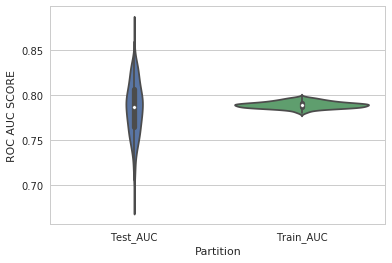

In [68]:
aucdf = pd.DataFrame({'Train_AUC':res['auc_train'], 'Test_AUC':res['auc_test']})
melted = pd.melt(aucdf, var_name="Partition", value_name='ROC AUC SCORE')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.violinplot(x="Partition", y='ROC AUC SCORE', data=melted)
plt.savefig("cogscoreslg.png", dpi=300, bbox_inches='tight')

In [78]:
from collections import Counter
def nonzero(x):
    return np.nonzero(x[0])[0]

cogdf = cog_five_scores[np.setdiff1d(utils.domain_scores, scores_to_remove)]
cogdfcols = cogdf.columns.values

cols = [cogdfcols[i] for i in [nonzero(res['coef_{}'.format(i)]) for i in range(400)]]
cols = [v for q in cols for v in q ]
col_count = dict(Counter(cols))
col_count

{'RPSdomainAvgZ': 400,
 'SOPdomainAvgZ': 400,
 'VISPAdomainAvgZ': 400,
 'VLMdomainAvgZ': 400,
 'VWMdomainAvgZ': 400}

In [ ]:
# should be able to make a regularization by accuracy by n_columns with
# the following things

In [99]:
pd.DataFrame(res['scores_1'][1])

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,...,0.773585,0.773585,0.773585,0.773585,0.773585,0.773585,0.773585,0.773585,0.773585,0.773585
1,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,...,0.754717,0.754717,0.754717,0.754717,0.754717,0.754717,0.754717,0.754717,0.754717,0.754717
2,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,...,0.817610,0.817610,0.817610,0.817610,0.817610,0.817610,0.817610,0.817610,0.817610,0.817610
3,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,0.415094,...,0.729560,0.729560,0.729560,0.729560,0.729560,0.729560,0.729560,0.729560,0.729560,0.729560


In [103]:
pd.DataFrame(res['coef_paths_1'][1][0])

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [104]:
pd.DataFrame(res['Cs_1'])

,0
0,0.000100
1,0.000102
2,0.000104
3,0.000106
4,0.000108
5,0.000110
6,0.000112
7,0.000114
8,0.000116
9,0.000118
